In [1]:
import os
import gc
import numpy as np
import pandas as pd
import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.ensemble import RandomForestRegressor
import math
%matplotlib inline

pd.set_option('display.max_columns', None)
base_dir = os.path.join(os.getcwd(), os.pardir)

In [2]:
data_path = os.path.join(base_dir, "data/altered/imputed/maps_xgboost_impute.csv")
data_path_dict= os.path.join(base_dir, "data/original/synthetic_data_dictionary.csv")

data = pd.read_csv(data_path)
data=pd.DataFrame(data,dtype=np.float32)

data_dict= pd.read_csv(data_path_dict)
data.drop('X',axis=1, inplace=True)

## Dimension Reudction

### Missing Value Ratio

### Low Variance Filter

Consider a variable in our dataset where all the observations have the same value, say 1. If we use this variable, do you think it can improve the model we will build? The answer is no, because this variable will have zero variance.

In [3]:
var=data.var()
columns = []

for i in range(0,len(data.var())):
    if var[i]> 0.8:
        columns.append(data.columns[i])

columns

['mat_dep',
 'mat_age',
 'weight_16',
 'height_16',
 'iq',
 'text_wend',
 'comp_wend',
 'tv_wend',
 'text_week',
 'comp_week',
 'tv_week',
 'num_home',
 'agg_score',
 'pat_ses',
 'mat_ses',
 'pat_edu',
 'mat_edu',
 'parity',
 'exercise',
 'prim_diag',
 'fam_tv_aft']

### High Correlation filter

High correlation between two variables means they have similar trends and are likely to carry similar information. This can bring down the performance of some models drastically (linear and logistic regression models, for instance). We can calculate the correlation between independent numerical variables that are numerical in nature. If the correlation coefficient crosses a certain threshold value, we can drop one of the variables (dropping a variable is highly subjective and should always be done keeping the domain in mind).

In [4]:
data.corr()

,comp_bed_9,mat_dep,mat_age,weight_16,height_16,iq,comp_noint_bed_16,comp_int_bed_16,talk_phon_wend,text_wend,talk_mob_wend,comp_wend,musi_wend,read_wend,work_wend,alon_wend,draw_wend,play_wend,tv_wend,out_win_wend,out_sum_wend,tran_wend,talk_phon_week,text_week,talk_mob_week,comp_week,musi_week,read_week,work_week,alon_week,draw_week,play_week,tv_week,out_win_week,out_sum_week,tran_week,pat_pres_10,pat_pres_8,pat_pres,num_home,mat_anx_1,mat_anx_18m,mat_anx_8m,agg_score,emot_cruel,phys_cruel,mat_anx_0m,pat_ses,mat_ses,pat_edu,mat_edu,parity,dep_band_15,dep_band_13,dep_band_10,dep_band_07,anx_band_15,anx_band_13,anx_band_10,anx_band_07,exercise,child_bull,phone_14_wend,phone_14_week,musi_13,tv_bed_9,own_mob,has_dep_diag,secd_diag,prim_diag,panic_score,dep_thoughts,dep_score,comp_house,tv_bed_16,creat_14,comp_games,fam_tv_eve,fam_tv_aft,fam_tv_mor,sex,birth_order
comp_bed_9,1.000000,0.015611,-0.015562,0.062644,0.066705,0.101789,0.017479,-0.017479,0.035834,0.045380,0.043655,0.046736,0.011014,0.018437,0.007067,0.038792,0.030437,0.031663,0.046745,0.032969,0.037259,0.025990,0.041220,0.048724,0.045910,0.046002,0.014365,0.024869,0.033079,0.030990,0.027642,0.038827,0.042284,0.036058,0.047493,0.035805,0.123062,0.122814,0.114928,0.124506,0.025286,0.009664,0.022826,0.057160,0.000681,0.003395,0.014267,0.054514,0.050176,0.005571,0.011902,-0.001404,0.019310,0.025711,0.041220,0.006558,0.025290,0.066463,0.080824,0.082936,0.041013,0.009284,0.052066,0.046597,0.046773,0.352040,0.104869,0.003995,0.002805,0.009503,0.004009,0.015415,0.006153,0.020206,0.080375,0.068363,0.111824,0.053305,0.034151,0.042247,-0.079313,0.000953
mat_dep,0.015611,1.000000,0.135818,0.030475,0.026501,0.038747,0.016215,-0.016215,0.020220,0.022029,0.013054,0.001435,0.012575,0.021711,0.018812,0.010991,0.014539,0.007173,0.013194,0.003366,0.016336,0.001884,0.018439,0.023784,0.013833,0.000159,0.024309,0.018996,0.018374,-0.005685,0.015160,0.013774,0.007570,0.001865,0.013358,0.012289,0.040074,0.058644,0.111778,0.133798,0.244160,0.271196,0.294617,0.125260,0.286099,0.147931,0.431176,0.073623,0.077048,0.082714,0.072531,0.073282,0.007262,0.027377,0.034628,0.054307,0.038772,0.098300,0.079428,0.116130,0.008973,0.017075,0.051656,0.046233,0.031112,0.041978,0.022308,0.015565,0.024131,0.019277,0.019154,0.019687,0.019877,0.012249,0.033242,0.035426,0.048655,0.150100,0.103617,0.128460,0.004837,0.012092
mat_age,-0.015562,0.135818,1.000000,0.115790,0.145425,0.224432,0.007442,-0.007442,0.130610,0.067265,0.070110,0.127940,0.109930,0.108317,0.123825,0.121266,0.092992,0.118320,0.124550,0.096607,0.125908,0.045157,0.119612,0.064407,0.066958,0.124699,0.115633,0.100537,0.102021,0.106290,0.091422,0.137098,0.117275,0.078716,0.076750,0.050654,0.228150,0.242371,0.278623,0.272040,0.107993,0.079224,0.091173,0.284046,0.029357,-0.026932,0.088482,0.001126,0.032710,0.319766,0.278165,0.317298,0.022155,0.021991,0.005703,-0.002813,0.106245,0.137534,0.124637,0.141309,0.144946,0.023239,0.124566,0.124674,0.156931,-0.012924,-0.022161,0.028960,0.023800,0.023834,-0.003659,0.029959,0.031579,0.038554,0.071609,0.103962,0.124361,0.204924,0.079756,0.085778,-0.050173,0.003989
weight_16,0.062644,0.030475,0.115790,1.000000,0.909031,0.462639,0.138518,-0.138518,0.347238,0.323951,0.330391,0.399831,0.223116,0.283249,0.294616,0.340191,0.265538,0.310856,0.391239,0.309909,0.368015,0.219948,0.331549,0.318430,0.327984,0.407026,0.217423,0.288169,0.293708,0.342986,0.275604,0.384680,0.391098,0.297725,0.295730,0.246356,0.311988,0.308126,0.215627,0.186896,0.053098,0.017348,0.024112,0.148277,0.002647,-0.011547,0.019075,-0.000123,0.029629,0.144075,0.163714,-0.025317,0.184025,0.056314,0.029148,0.021736,0.574348,0.279771,0.237610,0.206396,0.406990,0.151271,0.305253,0.309790,0.263659,0.113123,0.066172,0.102859,0.063504,0.125235,0.025871,0.194688,0.166899,0.108285,0.296777,0.229104,0.096947,0.123856,0.055192,0.070758,-0.039263,-0.014580
height_16,0.066705,0.026501,0.145425,0.909031,1.000000,0.514873,0.136039,-0.136039,0.376692,0.331287,0.349637,0.43814

## Feature selection

Use variance selection method like chi-square test method and mutual information method to score features, set the threshold or the number of thresholds to be selected to select, set "has_dep_diag" as the target,delete all the numerical features.

### chi square test

The null hypothesis for chi2 test is that "two categorical variables are independent". So a higher value of chi2 statistic means "two categorical variables are dependent" and MORE USEFUL for classification.

In [5]:
data_path = os.path.join(base_dir, "data/altered/imputed/maps_xgboost_impute.csv")
data = pd.read_csv(data_path)
data=pd.DataFrame(data,dtype=np.float32)
data.drop('X',axis=1, inplace=True)

y_target = data['has_dep_diag']
numerical_feature=['mat_age','height_16','iq','weight_16']
data=data.drop(['dep_score','dep_thoughts','has_dep_diag','prim_diag','secd_diag','panic_score','mat_age','height_16','iq','weight_16'],1)

In [6]:
from sklearn.feature_selection import SelectKBest, chi2,mutual_info_classif

In [7]:
bestfeatures = SelectKBest(score_func=chi2, k=30)
fit = bestfeatures.fit(data,y_target)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(data.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 5 best features

            Specs       Score
56       exercise  266.767874
7       comp_wend  197.634438
14        tv_wend  185.427071
21      comp_week  161.398609
5       text_wend  155.882561
28        tv_week  150.005822
19      text_week  138.754707
52    anx_band_15  123.890144
9       read_wend   93.400622
6   talk_mob_wend   91.426349


In [8]:
chi2_top10_features=['exercise','comp_wend','tv_wend','comp_week','text_wend','tv_week','text_week','anx_band_15','read_wend','talk_mob_wend']

In [9]:
# bestfeatures = SelectKBest(score_func=mutual_info_classif, k='all')
# fit = bestfeatures.fit(data,y_target)
# dfscores = pd.DataFrame(fit.scores_)
# dfcolumns = pd.DataFrame(data.columns)
# #concat two dataframes for better visualization 
# featureScores = pd.concat([dfcolumns,dfscores],axis=1)
# featureScores.columns = ['Specs','Score']  #naming the dataframe columns
# featureScores.to_csv('/Users/Egbert/Downloads/ADSMH-main/data/classification/mutual_info.csv')
# print(featureScores.nlargest(10,'Score'))  #print 5 best features

### kendalltau-b
Kendall’s tau is a measure of the correspondence between two rankings. Values close to 1 indicate strong agreement, and values close to -1 indicate strong disagreement. This implements two variants of Kendall’s tau: tau-b (the default) and tau-c (also known as Stuart’s tau-c). These differ only in how they are normalized to lie within the range -1 to 1; the hypothesis tests (their p-values) are identical. Kendall’s original tau-a is not implemented separately because both tau-b and tau-c reduce to tau-a in the absence of ties.

In [10]:
data_path = os.path.join(base_dir, "data/altered/imputed/maps_xgboost_impute.csv")
data = pd.read_csv(data_path)
data=pd.DataFrame(data,dtype=np.float32)
data.drop('X',axis=1, inplace=True)

In [11]:
from scipy import stats
target = ['has_dep_diag']
result=[]

for column in chi2_top10_features:
    tau, p_value = stats.kendalltau(data[column],data[target])
    temp_result = [column, tau, p_value]
    result.append(temp_result)
    #print("column name: {}, tau: {}, p-value: {}\n".format(column, tau, p_value))

result_chi2 = pd.DataFrame(result, columns=['feature name', 'tau correlation', 'p-value']) 

result_chi2

,feature name,tau correlation,p-value
0,exercise,0.092885,2.116442e-30
1,comp_wend,0.091358,1.761851e-29
2,tv_wend,0.092286,5.611878e-30
3,comp_week,0.088556,6.928970e-28
4,text_wend,0.086520,1.998243e-26
5,tv_week,0.088795,6.829048e-28
6,text_week,0.085586,7.268191e-26
7,anx_band_15,0.106314,7.274402e-36
8,read_wend,0.075978,7.861538e-20
9,talk_mob_wend,0.082041,3.488641e-23


The result indicate that there is not a strong correlation between these features and "has_dep_diag"

### spearman correlation

In [12]:
evidence_data = ['exercise','comp_wend','tv_wend','comp_week','text_wend','tv_week','text_week','anx_band_15','read_wend','talk_mob_wend','has_dep_diag']

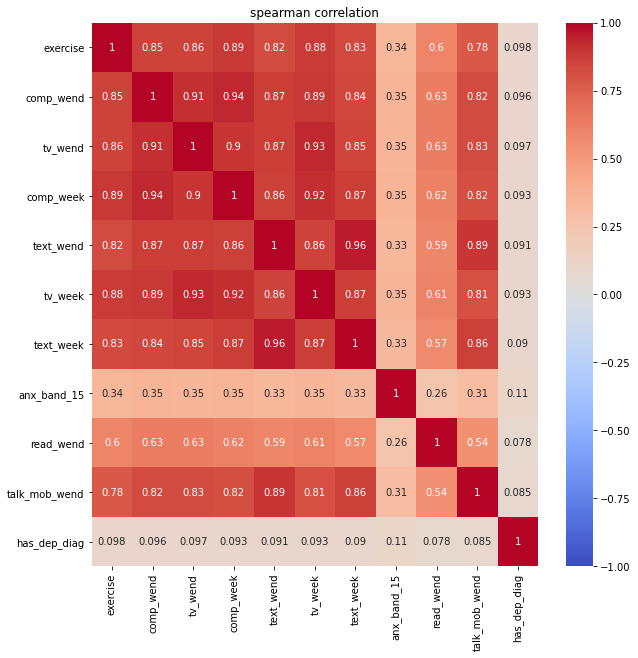

In [13]:
evidence_data=data[evidence_data]
figsave_dir = os.path.join(base_dir, "chi2_spearman_corr.png")
spearman_corr=evidence_data.corr(method='spearman')
fig = plt.figure(figsize=(10, 10))
ax = plt.title("spearman correlation")
ax = sns.heatmap(spearman_corr,cmap="coolwarm", vmin=-1, vmax=1,annot=True)
plt.savefig(figsave_dir, bbox_inches="tight", facecolor="white",dpi=200)
plt.show()

The result indicate that there is not a strong correlation between these features and "has_dep_diag"

In [14]:
top_10=['comp_wend', 'play_week','talk_mob_wend','tran_wend','alon_wend','tv_week','work_wend','anx_band_15','text_wend','musi_wend']
target = ['has_dep_diag']
result=[]

for column in top_10:
    tau, p_value = stats.kendalltau(data[column],data[target])
    temp_result = [column, tau, p_value]
    result.append(temp_result)
    #print("column name: {}, tau: {}, p-value: {}\n".format(column, tau, p_value))

result_mutual_info = pd.DataFrame(result, columns=['feature name', 'tau correlation', 'p-value']) 

result_mutual_info

,feature name,tau correlation,p-value
0,comp_wend,0.091358,1.761851e-29
1,play_week,0.087623,9.788992e-25
2,talk_mob_wend,0.082041,3.488641e-23
3,tran_wend,0.059337,3.562695e-12
4,alon_wend,0.083811,4.029662e-24
5,tv_week,0.088795,6.829048e-28
6,work_wend,0.083969,7.847197e-24
7,anx_band_15,0.106314,7.274402e-36
8,text_wend,0.086520,1.998243e-26
9,musi_wend,0.067181,3.468138e-15


### mutual information

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mutual_info_score.html

In [15]:
data_path = os.path.join(base_dir, "data/altered/imputed/maps_xgboost_impute.csv")
data = pd.read_csv(data_path)
data=pd.DataFrame(data,dtype=np.float32)
data.drop('X',axis=1, inplace=True)

y_target = data['has_dep_diag']
numerical_feature=['mat_age','height_16','iq','weight_16']
data=data.drop(['dep_score','dep_thoughts','has_dep_diag','prim_diag','secd_diag','panic_score','mat_age','height_16','iq','weight_16'],1)

In [16]:
bestfeatures = SelectKBest(score_func=mutual_info_classif, k='all')
fit = bestfeatures.fit(data,y_target)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(data.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores.to_csv('/Users/Egbert/Downloads/ADSMH-main/data/classification/mutual_info.csv')
print(featureScores.nlargest(10,'Score'))  #print 5 best features

           Specs     Score
24     work_week  0.006977
21     comp_week  0.006169
7      comp_wend  0.006141
14       tv_wend  0.005518
15  out_win_wend  0.005454
11     alon_wend  0.005349
31     tran_week  0.004989
17     tran_wend  0.004892
27     play_week  0.004838
33    pat_pres_8  0.004826


In [17]:
mutual_info_top10_features = ['anx_band_15','tv_wend','comp_week','tv_week','talk_mob_week','phone_14_wend','draw_wend','work_week','exercise','phone_14_week']

### kendalltau-b

In [18]:
data_path = os.path.join(base_dir, "data/altered/imputed/maps_xgboost_impute.csv")
data = pd.read_csv(data_path)
data=pd.DataFrame(data,dtype=np.float32)
data.drop('X',axis=1, inplace=True)

In [19]:
target = ['has_dep_diag']
result=[]

for column in mutual_info_top10_features:
    tau, p_value = stats.kendalltau(data[column],data[target])
    temp_result = [column, tau, p_value]
    result.append(temp_result)
    #print("column name: {}, tau: {}, p-value: {}\n".format(column, tau, p_value))

result_mutual_info = pd.DataFrame(result, columns=['feature name', 'tau correlation', 'p-value']) 

result_mutual_info

,feature name,tau correlation,p-value
0,anx_band_15,0.106314,7.274402e-36
1,tv_wend,0.092286,5.611878e-30
2,comp_week,0.088556,6.928970e-28
3,tv_week,0.088795,6.829048e-28
4,talk_mob_week,0.080323,3.316802e-22
5,phone_14_wend,0.083254,7.543723e-24
6,draw_wend,0.069032,1.513315e-16
7,work_week,0.091043,8.492058e-28
8,exercise,0.092885,2.116442e-30
9,phone_14_week,0.079616,7.447670e-22


The result indicate that there is not a strong correlation between these features and "has_dep_diag"

### spearman correlation

In [20]:
 evidence_data = ['anx_band_15','tv_wend','comp_week','tv_week','talk_mob_week','phone_14_wend','draw_wend','work_week','exercise','phone_14_week','has_dep_diag']

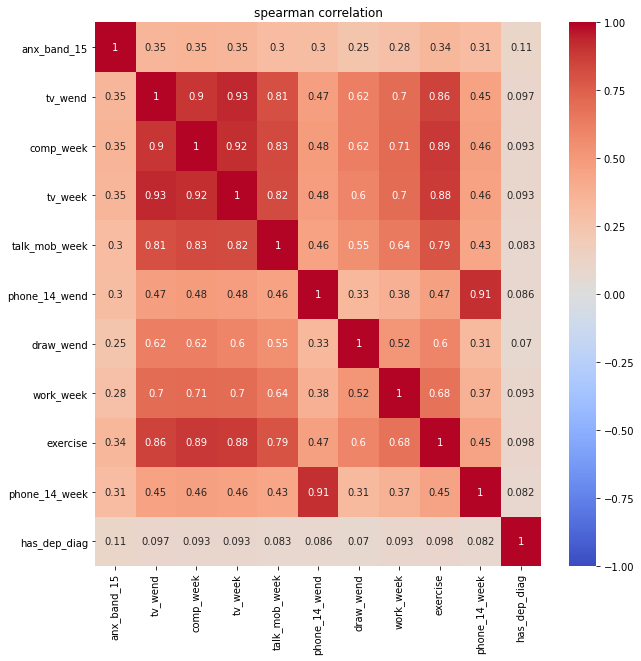

In [21]:
evidence_data=data[evidence_data]
figsave_dir = os.path.join(base_dir, "figures/mutual_info_spearman_corr.png")
spearman_corr=evidence_data.corr(method='spearman')
fig = plt.figure(figsize=(10, 10))
ax = plt.title("spearman correlation")
ax = sns.heatmap(spearman_corr,cmap="coolwarm", vmin=-1, vmax=1,annot=True)
plt.savefig(figsave_dir, bbox_inches="tight", facecolor="white",dpi=200)
plt.show()